# Бортников Павел Павлович 20215

In [127]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn as sk

Выгружаем cifar

In [128]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


50000

In [129]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


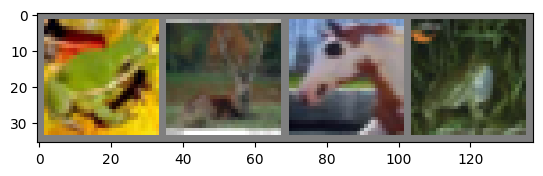

frog  deer  horse frog 


In [130]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

 Дальше будет 2 секции, которые я пытался запускать долго и мучительно - из примера с семинара и из официального примера. То, что раскоменчено - хотя бы запускается

In [131]:
# Пример нейронной сети с параметризуемым количеством и размером слоев,
# а также функцией активации
# class NeuralNetwork(nn.Module):
#     def __init__(self,
#                  input_size,
#                  num_layers=1,
#                  layer_size=100,
#                  activation=F.relu):
#         super().__init__()
#
#         # Инициализирируем слои
#         self.input_layer = nn.Linear(input_size, layer_size)
#         self.layers = []
#         for _ in range(num_layers - 1):
#             self.layers.append(nn.Linear(layer_size, layer_size))
#
#         # ModuleList нужен для того, чтобы to() применялся к модели корректно
#         self.layers = nn.ModuleList(self.layers)
#         self.output_layer = nn.Linear(layer_size, 1)
#
#         # Инициализируем функцию активации
#         self.activation = activation
#
#     def forward(self, input):
#         output = self.activation(self.input_layer(input))
#         for layer in self.layers:
#             output = self.activation(layer(output))
#         output = self.output_layer(output)
#
#         return output

Общая функция

In [132]:
# Параметризуемая функция - для удобства подбора параметров
# def train_model(model,
#                 train_dataloader,
#                 val_dataloader,
#                 device,
#                 num_epochs=10,
#                 lr=10e-5,
#                 show=True):
#     # Указываем модели, какие параметры сети оптимизировать (обучать)
#     # По факту - все, которые имеют градиенты
#     parameters = filter(lambda p: p.requires_grad, model.parameters())
#
#     # Задаем оптимизатор (можно параметризовать)
#     optimizer = optim.Adam(parameters, lr=lr)
#
#     # Задаем функцию потерь (в вашей задаче какую нужно использовать?)
#     loss_function = nn.BCEWithLogitsLoss()
#
#     train_losses = []
#     train_roc_aucs = []
#     val_losses = []
#     val_roc_aucs = []
#
#     # Итерируемся по эпохам
#     for e in range(num_epochs):
#         # Включаем режим обучения - разрешаем менять веса модели
#         model.train()
#
#         epoch_train_loss = 0
#         epoch_train_roc_auc = 0
#
#         # Проходимся по всему датасету
#         for X_batch, y_batch in train_dataloader:
#             # Помещаем тензоры на девайс (gpu или cpu в зависимости от инициализации device)
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#
#             # Обнуляем градиенты на каждом шаге обучения
#             optimizer.zero_grad()
#
#             # Делаем прямое распространение
#             y_pred = model(X_batch)
#
#             # Считаем значение функции потерь
#             loss = loss_function(y_pred, y_batch.unsqueeze(1))
#
#             # Считаем значение метрики (вы можете использовать другую)
#             roc_auc = sk.metrics.roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(),
#                                     torch.sigmoid(y_pred).ravel().cpu().detach().numpy())
#
#             # Делаем обратное распространение ошибки (обновляем веса модели)
#             loss.backward()
#             # Обновляем состояния оптимизатора
#             optimizer.step()
#
#             # Накапливаем значение функции потерь и метрики
#             epoch_train_loss += loss.item()
#             epoch_train_roc_auc += roc_auc.item()
#
#         # Включаем режим оценки - градиенты не накалпиваются при прямом распространении
#         model.eval()
#
#         epoch_val_loss = 0
#         epoch_val_roc_auc = 0
#
#         # Итерируемся по валидационной выборке
#         for X_batch, y_batch in val_dataloader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#
#             y_pred = model(X_batch)
#
#             loss = loss_function(y_pred, y_batch.unsqueeze(1))
#             roc_auc = sk.metrics.roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(),
#                                     torch.sigmoid(y_pred).ravel().cpu().detach().numpy())
#
#             epoch_val_loss += loss.item()
#             epoch_val_roc_auc += roc_auc.item()
#
#         # Считаем средние показатели за эпоху
#         train_losses.append(epoch_train_loss / len(train_dataloader))
#         train_roc_aucs.append(epoch_train_roc_auc / len(train_dataloader))
#         val_losses.append(epoch_val_loss / len(val_dataloader))
#         val_roc_aucs.append(epoch_val_roc_auc / len(val_dataloader))
#
#     # Строим график по всем эпохам
#     if show:
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
#         x = range(len(train_losses))
#         ax1.plot(x, train_losses, label='Train')
#         ax1.plot(x, val_losses, label='Val')
#         ax1.set_title('Loss')
#         ax1.set_xlabel('Epoch')
#         ax1.set_ylabel('Loss')
#         ax1.legend()
#         ax2.plot(x, train_roc_aucs, label='Train')
#         ax2.plot(x, val_roc_aucs, label='Val')
#         ax2.set_title('Metric (ROC AUC)')
#         ax2.set_xlabel('Epoch')
#         ax2.set_ylabel('ROC AUC')
#         ax2.legend()
#         plt.show()
#
#     # Возвращаем лучшее значение метрики на валидации
#     # Можно возвращать модель или все результаты, или ничего не возвращать
#     return np.array(val_roc_aucs).max()


In [133]:
# def test_layer_size(layer_size, num_layers=1, activation=F.relu, num_epochs=10, show=True):
#     if show:
#         print(f"Нейронов в скрытом слое: {layer_size}, функция активации: {str(activation)}")
#
#     model = NeuralNetwork(32, num_layers=num_layers, layer_size=layer_size, activation=activation)
#     # Перемещаем модель в видеопамять, если используется GPU
#     model.to(device)
#     best_metric = train_model(model, trainloader, testloader, device, num_epochs=num_epochs, show=show)
#
#     if show:
#         print(f"Лучший результат на валидации: {best_metric}")
#
#     return best_metric

In [134]:
# test_layer_size(3072, num_epochs=30);

---
## Дальше офф пример
---

In [135]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [136]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [137]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.223
[1,  4000] loss: 1.856
[1,  6000] loss: 1.669
[1,  8000] loss: 1.589
[1, 10000] loss: 1.523
[1, 12000] loss: 1.434
[2,  2000] loss: 1.396
[2,  4000] loss: 1.372
[2,  6000] loss: 1.337
[2,  8000] loss: 1.314
[2, 10000] loss: 1.318
[2, 12000] loss: 1.265
[3,  2000] loss: 1.204
[3,  4000] loss: 1.211
[3,  6000] loss: 1.208
[3,  8000] loss: 1.191
[3, 10000] loss: 1.158
[3, 12000] loss: 1.173
[4,  2000] loss: 1.095
[4,  4000] loss: 1.094
[4,  6000] loss: 1.099
[4,  8000] loss: 1.101
[4, 10000] loss: 1.106
[4, 12000] loss: 1.075
[5,  2000] loss: 1.019
[5,  4000] loss: 1.007
[5,  6000] loss: 1.022
[5,  8000] loss: 1.027
[5, 10000] loss: 1.038
[5, 12000] loss: 1.029
[6,  2000] loss: 0.943
[6,  4000] loss: 0.947
[6,  6000] loss: 0.998
[6,  8000] loss: 0.958
[6, 10000] loss: 0.981
[6, 12000] loss: 0.979
[7,  2000] loss: 0.868
[7,  4000] loss: 0.919
[7,  6000] loss: 0.914
[7,  8000] loss: 0.957
[7, 10000] loss: 0.953
[7, 12000] loss: 0.942
[8,  2000] loss: 0.842
[8,  4000] 

In [138]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

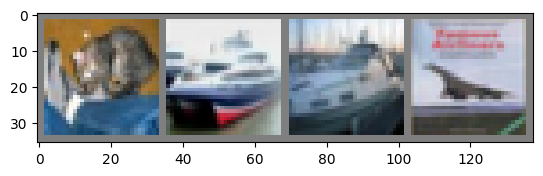

GroundTruth:  cat   ship  ship  plane


In [139]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [140]:
net = Net()
net.load_state_dict(torch.load(PATH))
# net.to(device)

<All keys matched successfully>

In [141]:
outputs = net(images)

In [142]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  ship 


In [143]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # inputs, labels = inputs.to(device), labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [144]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.8 %
Accuracy for class: car   is 82.5 %
Accuracy for class: bird  is 51.0 %
Accuracy for class: cat   is 36.6 %
Accuracy for class: deer  is 52.2 %
Accuracy for class: dog   is 62.5 %
Accuracy for class: frog  is 71.0 %
Accuracy for class: horse is 66.4 %
Accuracy for class: ship  is 73.6 %
Accuracy for class: truck is 68.2 %
